In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Displaying all columns and rows 
pd.options.display.max_columns = 10000
pd.options.display.max_rows = 10000000

# 1. Importing Data

In [2]:
train = pd.read_csv("train.csv") 
valid = pd.read_csv("validation.csv") 

In [3]:
train.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,trqRTvKaXTKfgg24JKTI,6447a7dfa30fe6eb410c91860e7c9b45,NaN,2015392487,200,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,NaN
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,20fc675468712705dbf5d3eda94126da,3ddf173a94bd23c326683b6373c75dd4,NaN,mm_10982364_973726_8930541,300,250,FourthView,Na,0,10722,294,23,NaN,2821,NaN
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,trqRTJn7O95I1mKYUV,625d1b5916ea925332c7b326c0574cfa,NaN,1720123646,250,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110"
3,0,6,23,0348beeae93e561584c3b50fc9e7746a33048ad7,0d6eaf2259699990e38a1fc5116f112070b9ecdc,windows_ie,114.250.226.*,1,1,1.0,5F97t5E0BTK7XhNrUMpENpn,dedc488b98ca20707bc9a723957e7d1f,NaN,mm_10027070_118039_10308280,160,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,25,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063,10111"
4,0,5,6,268149c1789bce2bc9798ffd97ec431219bafeb3,a239d9bb642460d974ba67f85e63b8d3e214da0e,windows_ie,183.63.192.*,216,233,2.0,13625cb070ffb306b425cd803c4b7ab4,4199d1227c511fc776b76594dabff9f8,NaN,1120200150,728,90,OtherView,Na,133,7330,277,133,NaN,2259,NaN


In [4]:
#train.shape

In [5]:
#valid.head()

In [6]:
#valid.shape

Testing set does not have click, bidprice and payprice

# 2. Data Pre-Processing

In [7]:
def preprocess(data, enforce_cols=None):
    ############### Handling useragent ################
    useragent_data= data['useragent'].str.split("_", n = 1, expand = True) 
    data['agent']= useragent_data[0] 
    data['browser']= useragent_data[1] 
    data.drop(columns =['useragent'], inplace = True) 
    
    ############# Computing a New Varialbe: slotsize ###############
    data['slotsize']=data.slotwidth*data.slotheight
    
    ############# Computing New Categorical Variables ###############
    data.ix[data.hour.between(0, 3), 'hour_'] = 1
    data.ix[data.hour.between(4, 7), 'hour_'] = 2
    data.ix[data.hour.between(8, 11), 'hour_'] = 3
    data.ix[data.hour.between(12, 15), 'hour_'] = 4
    data.ix[data.hour.between(16, 19), 'hour_'] = 5
    data.ix[data.hour.between(20, 23), 'hour_'] = 6
    data['hour_'] = data['hour_'].astype(np.uint8)
    
    data.ix[data.slotprice.between(0, 18), 'slotprice_'] = 1
    data.ix[data.slotprice.between(19, 67), 'slotprice_'] = 2
    data.ix[data.slotprice.between(68, 309), 'slotprice_'] = 3
    data.ix[data.slotprice.between(309, 1000000), 'slotprice_'] = 4
    data['slotprice_'] = data['slotprice_'].astype(np.uint8)
    
    ############## Dummy Coding ####################
    data = data.replace('Na',np.nan)
    data_dummy = pd.get_dummies(data, columns=['weekday','region','city','adexchange',
                                               'slotvisibility','slotformat','keypage',
                                               'advertiser','agent','browser','slotsize','slotprice_','hour_'
                                              ])

    ############# Drop Unwanted Variables ################
    data_dropped = data_dummy.drop(columns=['click','bidid', 'userid', 'IP','domain','url','urlid','slotid','bidprice',
                                            'payprice','slotheight','slotwidth','slotprice','hour','creative'])
    
    ############ Fill in NaNs with 0s #############
    data_na=data_dropped.fillna('0')
    
    ############ Handling usertag ################
    # Create a dataframe spliting usertag into variables and count
    usertag_= data_na.usertag.str.replace(',',' ')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(usertag_)
    usertag_data = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
    # Combining the usertag dataframe with the original dataframe
    data_final = pd.concat([data_na, usertag_data],sort=True,axis=1)
    data_final = data_final.drop(columns=['usertag'])
    
    ###### Matching the number of variables in the validation set with the training set ######
    #""""Reference: DrivenDataLabs, 2017, BENCHMARK FOR POVER-T TEST - PREDICTING POVERTY
        #url: http://drivendata.co/blog/worldbank-poverty-benchmark/""""
    if enforce_cols is not None:
        drop = np.setdiff1d(data_final.columns, enforce_cols)
        add = np.setdiff1d(enforce_cols, data_final.columns)

        data_final.drop(drop, axis=1, inplace=True)
        data_final = data_final.assign(**{c: 0 for c in add})
    
    print(data_final.shape)
    
    return data_final

In [8]:
train_new = preprocess(train)
valid_new = preprocess(valid,enforce_cols=train_new.columns)
valid_new = valid_new[train_new.columns]

(2430981, 574)
(303925, 574)


In [9]:
#train_new.head()

In [10]:
#valid_new.head()

In [11]:
#valid_new.head()

In [12]:
y = train['click']
y_val = valid['click']

# 3. Train Model

## 3.1 Treating imbalanced data

In [13]:
# Separate click and unclick
resample_num = pd.to_numeric(train['click'])
resample_data = pd.concat([resample_num, train_new],axis=1)

df_majority = resample_data[resample_data.click==0]
df_minority = resample_data[resample_data.click==1]
 
# Downsample unclick
size=int((len(y)-sum(y))*0.03)
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=size,  # ratio
                                 random_state=1) # reproducible results

# Combine 
downsampled = pd.concat([df_majority_downsampled, df_minority])
 
downsampled.click.value_counts()

0    72875
1     1793
Name: click, dtype: int64

In [14]:
# Separate into features and target variable
y_new = downsampled.click
x_new = downsampled.drop('click', axis=1)

In [15]:
#print(y_new.shape)
#print(x_new.shape)

## 3.2 Logistic Regression

In [16]:
best_LR = LogisticRegression(penalty='l1', C=0.1, class_weight='unbalanced', random_state=3, solver='saga')

best_LR.fit(x_new, y_new)

y_valid_p = best_LR.predict_proba(valid_new)
print('Area Under ROC Curve:',round(roc_auc_score(y_val, y_valid_p[:,1]),3))

Area Under ROC Curve: 0.826


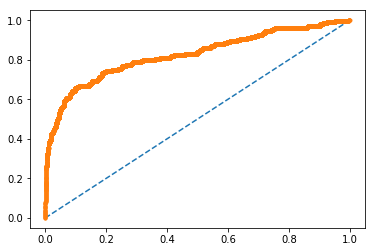

In [17]:
fpr, tpr, thresholds = roc_curve(y_val, y_valid_p[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

# 4. Bidding

## 4.1 Bidding Mechanism

In [18]:
def bidding(bidprice):
    budget = 6250
    imps = 0
    click = 0
    for i in range(0, len(valid)):
        if budget < valid.payprice[i]:
            break
        if bidprice[i] >= valid.payprice[i]:
            budget = budget - valid.payprice[i]/1000
            imps += 1
            if valid.click[i]==1:
                click += 1
    
    click = click
    imps = imps
    CTR = click/imps
    spend = 6250-budget
    CPM = spend/imps
    eCPC = spend/click
    
    return click, imps, spend, CTR, CPM, eCPC

## 4.2 Inputs

In [19]:
#average CTR
avgCTR = sum(y)/len(y)

#validation pCTR
pCTR_valid_before = y_valid_p[:,1]
pCTR_valid = pCTR_valid_before / (pCTR_valid_before +(1-pCTR_valid_before)/0.03)

## 4.3 LR+Non-Linear Bidding Strategies

### 4.3.1 LR + Optimal Real-Time Bidding (ORTB)

In [23]:
ORTB = pd.DataFrame(columns = ['c0', 'lambda0', 'Imps', 'Spend', 'Click'])

c0 = 0
lambda0 = 0
lambda_domain = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4]
iteration = 0
max_num = 0

for c in np.arange(4,25,2):
    for m in lambda_domain:
        iteration += 1
        bid = np.sqrt(c * pCTR_valid / m + c*c) - c
        
        click, imps, spend, CTR, CPM, eCPC = bidding(bid)
        
        if click > max_num:
                max_num = click
                lambda0 = m
                c0 = c
                
        ORTB.loc[iteration,'Imps'] = imps
        ORTB.loc[iteration,'c0'] = c0
        ORTB.loc[iteration,'lambda0'] = lambda0
        ORTB.loc[iteration,'Click'] = click
        ORTB.loc[iteration,'Spend'] = round(spend,2)
        ORTB.loc[iteration,'CTR'] = round(CTR,5)
        ORTB.loc[iteration,'CPM'] = round(CPM*1000,2)
        ORTB.loc[iteration,'eCPC'] = round(eCPC,2)

In [24]:
ORTB.head()

,c0,lambda0,Imps,Spend,Click,CTR,CPM,eCPC
1,4.0,1e-08,78926.0,5957.99,51.0,0.00065,75.49,116.82
2,4.0,5e-08,92088.0,5953.94,64.0,0.00069,64.65,93.03
3,4.0,1e-07,105553.0,5980.14,77.0,0.00073,56.66,77.66
4,4.0,5e-07,124285.0,4737.7,137.0,0.00110,38.12,34.58
5,4.0,5e-07,79943.0,2183.83,112.0,0.00140,27.32,19.50


In [25]:
ORTB.iloc[np.where(ORTB.Click == ORTB.Click.max())[0]]

,c0,lambda0,Imps,Spend,Click,CTR,CPM,eCPC
45,12.0,1e-06,140802.0,5932.29,148.0,0.00105,42.13,40.08


### 4.3.2 LR + Quadratic bidding

In [26]:
Qaud = pd.DataFrame(columns=['Base_bid','Imps','Spend','Click'])

iteration = 0
for i in np.arange(3,300,3):
    iteration += 1
    base_bid = i
    #Non-linear strategy inputs to get bid price 
    bid = base_bid * (pCTR_valid / avgCTR)**2
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Qaud.loc[iteration,'Base_Bid'] = base_bid
    Qaud.loc[iteration,'Imps'] = imps
    Qaud.loc[iteration,'Click'] = click
    Qaud.loc[iteration,'Spend'] = round(spend,2)
    Qaud.loc[iteration,'CTR'] = round(CTR,5)
    Qaud.loc[iteration,'CPM'] = round(CPM*1000,2)
    Qaud.loc[iteration,'eCPC'] = round(eCPC,2)

In [27]:
Qaud.head()

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
1,NaN,9305.0,535.03,84.0,3.0,0.00903,57.50,6.37
2,NaN,13546.0,805.95,95.0,6.0,0.00701,59.50,8.48
3,NaN,17165.0,1017.88,102.0,9.0,0.00594,59.30,9.98
4,NaN,20604.0,1208.14,108.0,12.0,0.00524,58.64,11.19
5,NaN,23913.0,1387.2,114.0,15.0,0.00477,58.01,12.17


In [28]:
Qaud.iloc[np.where(Qaud.Click == Qaud.Click.max())[0]]

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
35,NaN,102101.0,5869.68,153.0,105.0,0.0015,57.49,38.36


### 4.3.3 LR + Exponential bidding

In [29]:
Exp = pd.DataFrame(columns=['Base_bid','Imps','Spend','Click'])

iteration = 0
for i in np.arange(3,303,3):
    iteration += 1
    base_bid = i
    #Non-linear strategy inputs to get bid price 
    bid = base_bid * np.exp(pCTR_valid/avgCTR)
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Exp.loc[iteration,'Base_Bid'] = base_bid
    Exp.loc[iteration,'Imps'] = imps
    Exp.loc[iteration,'Click'] = click
    Exp.loc[iteration,'Spend'] = round(spend,2)
    Exp.loc[iteration,'CTR'] = round(CTR,5)
    Exp.loc[iteration,'CPM'] = round(CPM*1000,2)
    Exp.loc[iteration,'eCPC'] = round(eCPC,2)

In [30]:
Exp.head()

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
1,NaN,18047.0,991.62,101.0,3.0,0.00560,54.95,9.82
2,NaN,31152.0,1339.52,113.0,6.0,0.00363,43.00,11.85
3,NaN,43056.0,1704.18,116.0,9.0,0.00269,39.58,14.69
4,NaN,58930.0,2193.75,125.0,12.0,0.00212,37.23,17.55
5,NaN,75249.0,2745.7,133.0,15.0,0.00177,36.49,20.64


In [31]:
Exp.iloc[np.where(Exp.Click == Exp.Click.max())[0]]

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
9,NaN,129071.0,5397.97,154.0,27.0,0.00119,41.82,35.05


## 4.4 Gradient Boosting Classifier (GBC) + Non-Linear Bidding Strategies

In [32]:
gbc = ensemble.GradientBoostingClassifier(**{'n_estimators': 250, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'deviance'})
gbc.fit(x_new, y_new)
pred_y_gbc = gbc.predict_proba(valid_new)

In [33]:
auc1=roc_auc_score(y_val, pred_y_gbc[:,1])

In [34]:
print(auc1)

0.8826088864257274


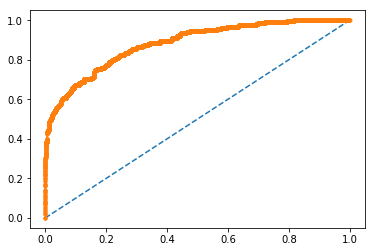

In [35]:
fpr, tpr, thresholds = roc_curve(y_val, pred_y_gbc[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
#plt.savefig('Q4.png',dpi=300)
plt.show()

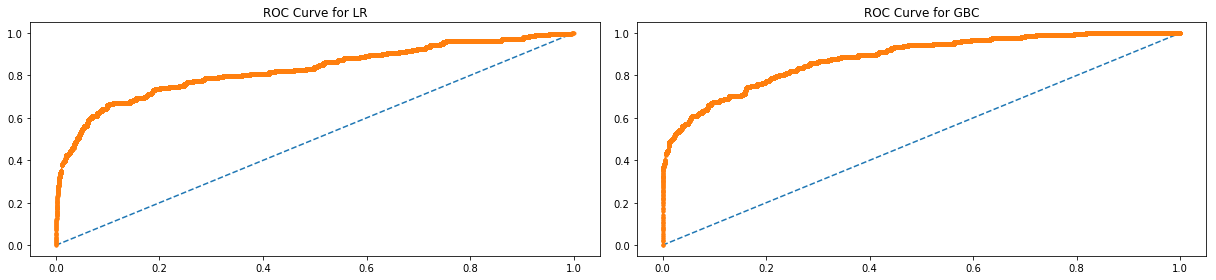

In [36]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(17,4))

fpr, tpr, thresholds = roc_curve(y_val, y_valid_p[:,1])
ax1.plot([0, 1], [0, 1], linestyle='--')
ax1.plot(fpr, tpr, marker='.')
ax1.set_title("ROC Curve for LR")

fpr1, tpr1, thresholds1 = roc_curve(y_val, pred_y_gbc[:,1])
ax2.plot([0, 1], [0, 1], linestyle='--')
ax2.plot(fpr1, tpr1, marker='.')
ax2.set_title("ROC Curve for GBC")
plt.savefig('ROC ALL.png',dpi=300)
plt.tight_layout()

In [37]:
#average CTR
avgCTR = sum(y)/len(y)

#validation pCTR
pCTR_valid_gbc_before = pred_y_gbc[:,1]
pCTR_valid_gbc = pCTR_valid_gbc_before / (pCTR_valid_gbc_before +(1-pCTR_valid_gbc_before)/0.03)

### 4.4.1 GBC + ORTB

In [38]:
ORTB1 = pd.DataFrame(columns = ['c0', 'lambda0', 'Imps', 'Spend', 'Click'])

c0 = 0
lambda0 = 0
lambda_domain = [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4]
iteration = 0
max_num = 0

for c in np.arange(4,25,2):
    for m in lambda_domain:
        iteration += 1
        bid = np.sqrt(c * pCTR_valid_gbc / m + c*c) - c
        
        click, imps, spend, CTR, CPM, eCPC = bidding(bid)
        
        if click > max_num:
                max_num = click
                lambda0 = m
                c0 = c
                
        ORTB1.loc[iteration,'Imps'] = imps
        ORTB1.loc[iteration,'c0'] = c0
        ORTB1.loc[iteration,'lambda0'] = lambda0
        ORTB1.loc[iteration,'Click'] = click
        ORTB1.loc[iteration,'Spend'] = round(spend,2)
        ORTB1.loc[iteration,'CTR'] = round(CTR,5)
        ORTB1.loc[iteration,'CPM'] = round(CPM*1000,2)
        ORTB1.loc[iteration,'eCPC'] = round(eCPC,2)

In [39]:
ORTB1.head()

,c0,lambda0,Imps,Spend,Click,CTR,CPM,eCPC
1,4.0,1e-08,76979.0,5965.84,49.0,0.00064,77.50,121.75
2,4.0,5e-08,95171.0,5969.13,64.0,0.00067,62.72,93.27
3,4.0,1e-07,111126.0,5969.2,80.0,0.00072,53.72,74.62
4,4.0,5e-07,107674.0,3364.89,136.0,0.00126,31.25,24.74
5,4.0,5e-07,72783.0,1700.07,113.0,0.00155,23.36,15.04


In [40]:
ORTB1.iloc[np.where(ORTB1.Click == ORTB1.Click.max())[0]]

,c0,lambda0,Imps,Spend,Click,CTR,CPM,eCPC
85,20.0,1e-06,145960.0,5877.55,160.0,0.0011,40.27,36.73


### 4.4.2 GBC + Quadratic

In [41]:
Qaud1 = pd.DataFrame(columns=['Base_bid','Imps','Spend','Click'])

iteration = 0
for i in np.arange(3,300,3):
    iteration += 1
    base_bid = i
    #Non-linear strategy inputs to get bid price 
    bid = base_bid * (pCTR_valid_gbc/ avgCTR)**2
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Qaud1.loc[iteration,'Base_Bid'] = base_bid
    Qaud1.loc[iteration,'Imps'] = imps
    Qaud1.loc[iteration,'Click'] = click
    Qaud1.loc[iteration,'Spend'] = round(spend,2)
    Qaud1.loc[iteration,'CTR'] = round(CTR,5)
    Qaud1.loc[iteration,'CPM'] = round(CPM*1000,2)
    Qaud1.loc[iteration,'eCPC'] = round(eCPC,2)

In [42]:
Qaud1.head()

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
1,NaN,6739.0,334.08,91.0,3.0,0.01350,49.57,3.67
2,NaN,9589.0,511.44,102.0,6.0,0.01064,53.34,5.01
3,NaN,11618.0,631.12,107.0,9.0,0.00921,54.32,5.90
4,NaN,13522.0,734.49,108.0,12.0,0.00799,54.32,6.80
5,NaN,15553.0,844.67,113.0,15.0,0.00727,54.31,7.47


In [43]:
Qaud1.iloc[np.where(Qaud1.Click == Qaud1.Click.max())[0]]

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
70,NaN,105465.0,5869.78,159.0,210.0,0.00151,55.66,36.92
71,NaN,106498.0,5934.36,159.0,213.0,0.00149,55.72,37.32


### 4.4.3 GBC + Exponential

In [44]:
Exp1 = pd.DataFrame(columns=['Base_bid','Imps','Spend','Click'])

iteration = 0
for i in np.arange(3,303,3):
    iteration += 1
    base_bid = i
    #Non-linear strategy inputs to get bid price 
    bid = base_bid * np.exp(pCTR_valid_gbc/avgCTR)
    #bidding mechanism
    click, imps, spend, CTR, CPM, eCPC = bidding(bid)
    #feeding data into a dataframe
    Exp1.loc[iteration,'Base_Bid'] = base_bid
    Exp1.loc[iteration,'Imps'] = imps
    Exp1.loc[iteration,'Click'] = click
    Exp1.loc[iteration,'Spend'] = round(spend,2)
    Exp1.loc[iteration,'CTR'] = round(CTR,5)
    Exp1.loc[iteration,'CPM'] = round(CPM*1000,2)
    Exp1.loc[iteration,'eCPC'] = round(eCPC,2)

In [45]:
Exp1.head()

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
1,NaN,12655.0,614.84,108.0,3.0,0.00853,48.58,5.69
2,NaN,24215.0,843.58,110.0,6.0,0.00454,34.84,7.67
3,NaN,33757.0,1095,118.0,9.0,0.00350,32.44,9.28
4,NaN,44411.0,1381.25,121.0,12.0,0.00272,31.10,11.42
5,NaN,60766.0,1817.39,131.0,15.0,0.00216,29.91,13.87


In [46]:
Exp1.iloc[np.where(Exp1.Click == Exp1.Click.max())[0]]

,Base_bid,Imps,Spend,Click,Base_Bid,CTR,CPM,eCPC
12,NaN,140496.0,5601.51,159.0,36.0,0.00113,39.87,35.23


## ------------------ Comparison Between LR and GBC ----------------------

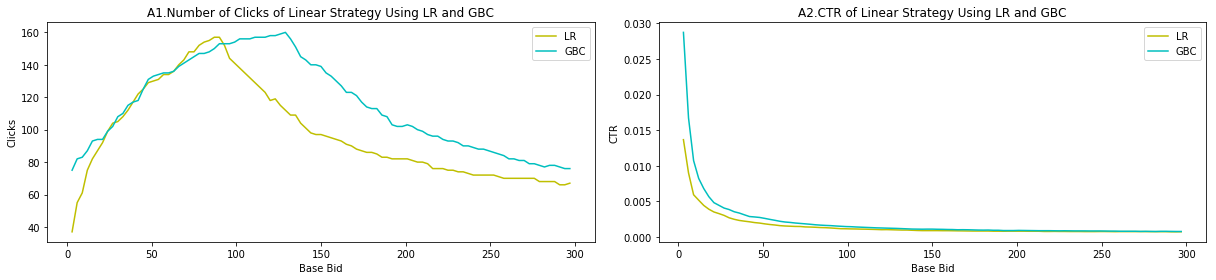

In [50]:
fig, (ax1, ax2)=plt.subplots(1,2, figsize = (17,4))
ax1.plot(linear.Base_Bid,linear.Click,color='y',label='LR')
ax1.set_ylabel('Clicks')
ax1.set_xlabel('Base Bid')
ax1.plot(linear1.Base_Bid, linear1.Click, color='c',label='GBC')
ax1.legend()
ax1.set_title("A1.Number of Clicks of Linear Strategy Using LR and GBC")

ax2.plot(linear.Base_Bid,linear.CTR,color='y',label='LR')
ax2.set_ylabel('CTR')
ax2.set_xlabel('Base Bid')
ax2.plot(linear1.Base_Bid, linear1.CTR, color='c',label='GBC')
ax2.legend()
ax2.set_title("A2.CTR of Linear Strategy Using LR and GBC")

plt.tight_layout()
plt.savefig('LRGBCLS.png',dpi=300)

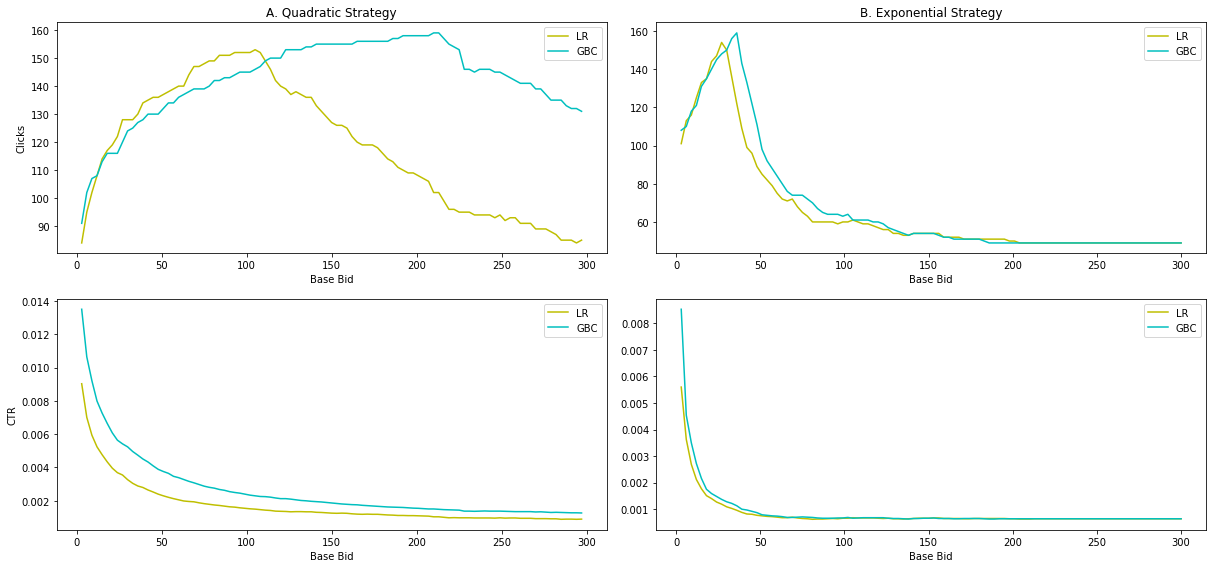

In [51]:
fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2, figsize = (17,8))


ax1.plot(Qaud.Base_Bid,Qaud.Click,color='y',label='LR')
ax1.set_xlabel('Base Bid')
ax1.set_ylabel('Clicks')
ax1.plot(Qaud1.Base_Bid, Qaud1.Click, color='c',label='GBC')
ax1.set_title("A. Quadratic Strategy")
ax1.legend()

ax3.plot(Qaud.Base_Bid,Qaud.CTR,color='y',label='LR')
ax3.set_xlabel('Base Bid')
ax3.set_ylabel('CTR')
ax3.plot(Qaud1.Base_Bid, Qaud1.CTR, color='c',label='GBC')
ax3.legend()
#ax3.set_title("A2. Quadratic Strategy CTR")

ax2.plot(Exp.Base_Bid,Exp.Click,color='y',label='LR')
ax2.set_xlabel('Base Bid')
ax2.plot(Exp1.Base_Bid, Exp1.Click, color='c',label='GBC')
ax2.set_title("B. Exponential Strategy")
ax2.legend()

ax4.plot(Exp.Base_Bid,Exp.CTR,color='y',label='LR')
ax4.set_xlabel('Base Bid')
ax4.plot(Exp1.Base_Bid, Exp1.CTR, color='c',label='GBC')
#ax4.set_title("B2. Exponential Strategy CTR")
ax4.legend()

plt.tight_layout()
plt.savefig('Q4.png',dpi=300)